Import all necessary libraries

In [5]:
# Numerical libraries
import numpy as np   

# Import Linear Regression machine learning library
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

from sklearn.metrics import r2_score

# to handle data in form of rows and columns 
import pandas as pd    

# importing ploting libraries
import matplotlib.pyplot as plt   

import statsmodels.formula.api as sm

#importing seaborn for statistical plots
import seaborn as sns

import hashlib
import datetime

# import time
# from datetime import datetime
from time import strftime, gmtime

import statsmodels.formula.api as smf
#maschine learning libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVC
from random import sample

sns.set_theme(style="darkgrid")
from data_loading import load_data
from functions import *




Import and preprocess the data 

In [4]:
# import data by using the load_data() function
flights_test, flights_train = load_data()


Retrieve only unique values 

In [10]:
# copied this from your part

unique_origin_airports = flights_train['ORIGIN_AIRPORT'].drop_duplicates()
unique_destination_airports = flights_train['DESTINATION_AIRPORT'].drop_duplicates()

connections = flights_train[['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']]
unique_connections = connections.drop_duplicates()

Visualize average delay per airline

In [11]:
# Group by airline and sum up / count the values
df_flights_grouped_sum = flights_train.groupby('AIRLINE', as_index= False)['ARRIVAL_DELAY'].agg('sum').rename(columns={"ARRIVAL_DELAY":"ARRIVAL_DELAY_SUM"})
df_flights_grouped_cnt = flights_train.groupby('AIRLINE', as_index= False)['ARRIVAL_DELAY'].agg('count').rename(columns={"ARRIVAL_DELAY":"ARRIVAL_DELAY_CNT"})

# Merge the two groups together
df_flights_grouped_delay = df_flights_grouped_sum.merge(df_flights_grouped_cnt, left_on='AIRLINE', right_on='AIRLINE', how='inner')
# Calculate the average delay per airline
df_flights_grouped_delay.loc[:,'AVG_DELAY_AIRLINE'] = df_flights_grouped_delay['ARRIVAL_DELAY_SUM'] / df_flights_grouped_delay['ARRIVAL_DELAY_CNT']

df_flights_grouped_delay.sort_values('ARRIVAL_DELAY_SUM', ascending=False)

,AIRLINE,ARRIVAL_DELAY_SUM,ARRIVAL_DELAY_CNT,AVG_DELAY_AIRLINE
13,WN,3057901.0,610684,5.007338
4,EV,2457505.0,285191,8.617050
10,UA,1938434.0,244880,7.915853
9,OO,1841248.0,285220,6.455536
7,MQ,1769260.0,149746,11.815074
0,AA,1677814.0,256098,6.551453
8,NK,953644.0,54239,17.582256
2,B6,887149.0,127305,6.968689
5,F9,766541.0,42287,18.127108
11,US,719831.0,194223,3.706209


Check if any significant correlations occur

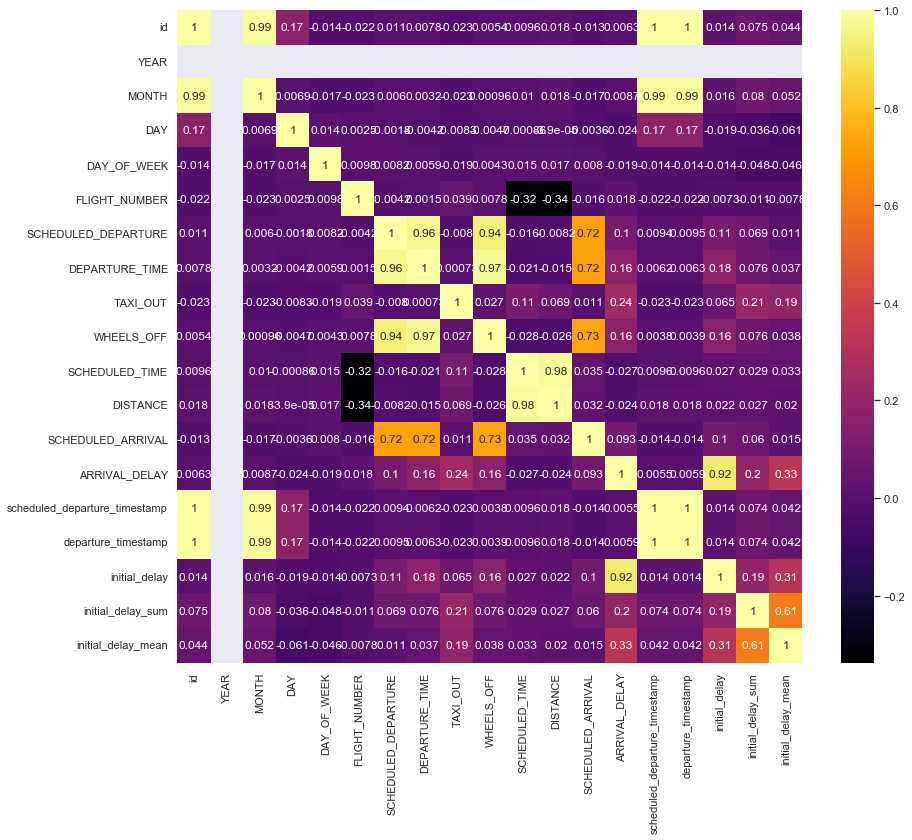

In [12]:
# Dataframe correlation
del_corr = flights_train.corr()

# Draw the figure
f, ax = plt.subplots(figsize=(14, 12))

# Draw the heatmap
sns.heatmap(del_corr,annot=True,cmap='inferno')
plt.show()